# o'reillyのネゴザメ言語モデルの本
RNN Encoder-Decoder（Sequence-to-Sequence）

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インストール](#インストール)
  - [インポート](#インポート)
- [RNN Encoder-Decoder（Sequence-to-Sequence）](#RNN_Encoder-Decoder（Sequence-to-Sequence）)
  - [Encoder](#Encoder)
  - [Decoder](#Decoder)
  - [Encoder-Decoder](#Encoder-Decoder)
  - [Encoder-Decoder改](#Encoder-Decoder改)

## 参考
- https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch07
- [RNN Encoder-Decoder（Sequence-to-Sequence） - 開発基盤部会 Wiki](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?RNN%20Encoder-Decoder%EF%BC%88Sequence-to-Sequence%EF%BC%89)

## 環境準備

### インストール

In [ ]:
!pip install numpy
!pip install matplotlib

### インポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定

## RNN_Encoder-Decoder（Sequence-to-Sequence）
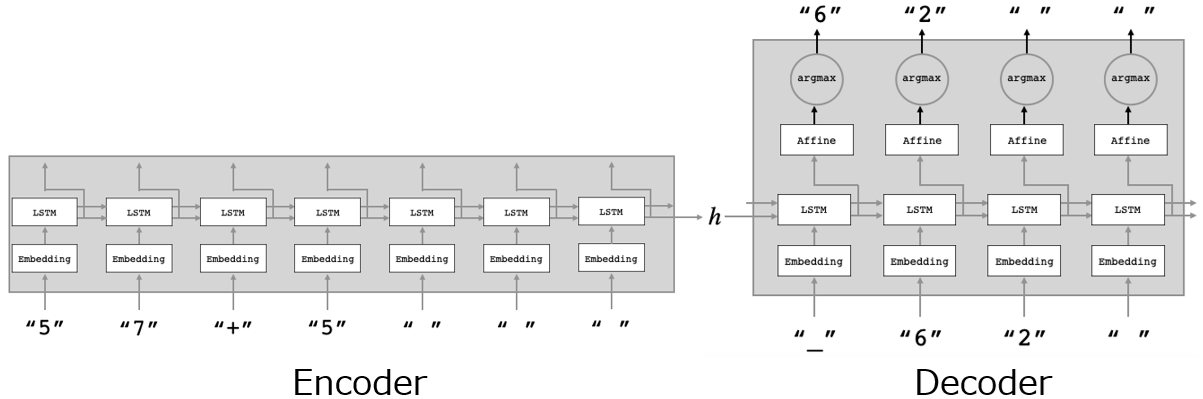

### Encoder

#### 定義

In [ ]:
from nekozame.common.time_layers import TimeEmbedding
from nekozame.common.time_layers import TimeLSTM

In [ ]:
# エンコーダーの実装
class Encoder:
    # 初期化メソッド
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 変数の形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # パラメータを初期化
        embed_W = (np.random.randn(V, D) * 0.01).astype('f')
        lstm_Wx = (np.random.randn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        
        # レイヤのインスタンスを作成
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        # パラメータと勾配をリストに格納
        self.params = self.embed.params + self.lstm.params # パラメータ
        self.grads = self.embed.grads + self.lstm.grads    # 勾配
        
        # LSTMレイヤの中間変数を初期化
        self.hs = None
    
    # 順伝播メソッド
    def forward(self, xs):
        # 各レイヤの順伝播を計算
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        
        # 逆伝播用に隠れ状態を保存
        self.hs = hs
        
        # T-1番目の隠れ状態をDecoderに出力
        return hs[:, -1, :]
    
    # 逆伝播メソッド
    def backward(self, dh):
        # 隠れ状態を初期化
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh # Decoderから入力
        
        # 各レイヤの逆伝播を逆順に計算
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

#### 実行

##### データの準備

In [ ]:
# データとパラメータの形状に関する値を指定
N = 6 # バッチサイズ
T = 7 # 時系列サイズ
V = 13 # 単語の種類数
D = 15 # 単語ベクトル(Embedレイヤの中間層)のサイズ
H = 10 # 隠れ状態(LSTMレイヤの中間層)のサイズ

# 順伝播の入力を生成
xs = np.random.randint(low=0, high=V, size=(N, T))
print('xs:', xs)
print('xs.shape:', xs.shape)

# 逆伝播の入力を生成
dh = np.ones((N, H))
print('dh:', dh)
print('dh.shape:', dh.shape)

##### 順伝播と逆伝播

In [ ]:
# Encoderのインスタンスを作成
encoder = Encoder(V, D, H)

# 順伝播の計算
h = encoder.forward(xs)
print('h:', np.round(h, 3))
print('h.shape:', h.shape)

# 逆伝播の計算
dout = encoder.backward(dh)
print('dout:', dout)

### Decoder

#### 定義

In [ ]:
from nekozame.common.time_layers import TimeEmbedding
from nekozame.common.time_layers import TimeLSTM
from nekozame.common.time_layers import TimeAffine

In [ ]:
# デコーダーの定義
class Decoder:
    # 初期化メソッド
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 変数の形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # パラメータを初期化
        embed_W = (np.random.randn(V, D) * 0.01).astype('f')
        lstm_Wx = (np.random.randn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤを生成
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        # パラメータと勾配をリストに格納
        self.params = [] # パラメータ
        self.grads = []  # 勾配
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
    # 順伝播メソッド
    def forward(self, xs, h):
        # Encoderの隠れ状態を入力
        self.lstm.set_state(h)
        
        # 各レイヤの順伝播を計算
        # Time Embedレイヤの順伝播を計算
        out = self.embed.forward(xs)
        # Time LSTMレイヤの順伝播を計算
        out = self.lstm.forward(out)
        # Time Affineレイヤの順伝播を計算
        score = self.affine.forward(out)
        return score
    
    # 逆伝播メソッド
    def backward(self, dscore):
        # 各レイヤの逆伝播を逆順に計算
        # Time Affineレイヤの逆伝播を計算
        dout = self.affine.backward(dscore)
        # Time LSTMレイヤの逆伝播を計算
        dout = self.lstm.backward(dout)
        # Time Embedレイヤの逆伝播を計算
        dout = self.embed.backward(dout)
        
        # EncoderのT-1番目の隠れ状態の勾配をEncoderに出力
        dh = self.lstm.dh
        return dh
    
    # 文章生成メソッド
    def generate(self, h, start_id, sample_size):
        # 文字IDの受け皿を初期化
        sampled = []
        
        # 区切り文字のIDを設定
        sample_id = start_id
        
        # エンコードされた足し算の式を入力
        self.lstm.set_state(h)
        
        # 解答を生成
        for _ in range(sample_size):
            # 入力用に2次元配列に変換
            x = np.array(sample_id).reshape((1, 1))
            
            # スコアを計算
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            # スコアが最大の文字IDを取得
            sample_id = np.argmax(score.flatten()) # 入力データを更新
            sampled.append(sample_id) # サンプルを保存
        
        return sampled

#### 実行

##### データの準備

In [ ]:
# データとパラメータの形状に関する値を指定
N = 6 # バッチサイズ
T = 4 # 時系列サイズ
V = 13 # 単語の種類数
D = 15 # 単語ベクトル(Embedレイヤの中間層)のサイズ
H = 10 # 隠れ状態(LSTMレイヤの中間層)のサイズ

# 順伝播の入力を生成

## xs
xs = np.random.randint(low=0, high=V, size=(N, T))
print('xs:', xs)
print('xs.shape:', xs.shape)

## h（Encoderからの入力を作成）
h = np.random.randn(N, H)
print(np.round(h, 2))
print(h.shape)

# 逆伝播の入力を生成
dscore = np.ones((N, T, V))
#print('dscore:', dscore)
print('dscore.shape:', dscore.shape)

##### 順伝播と逆伝播

In [ ]:
# Decoderのインスタンスを作成
decoder = Decoder(V, D, H)

# 順伝播の計算
score = decoder.forward(xs, h)
print(np.round(score[0], 2))
print(score.shape)

# 逆伝播の計算
dh = decoder.backward(dscore)
print(np.round(dh, 3))
print(dh.shape)

##### generate

In [ ]:
# 最初に入力する単語のIDを指定
start_id = 6

# サンプリングする単語数を指定
sample_size = 4

# (簡易的に)Encoderからの入力を作成
h = np.random.randn(1, H)
print(h.shape)

# 文章を生成
sampled = decoder.generate(h, start_id, sample_size)
print(sampled)

### Encoder-Decoder

#### 定義

In [ ]:
from nekozame.common.time_layers import TimeSoftmaxWithLoss

In [ ]:
# seq2seqの実装
class Seq2seq:
    # 初期化メソッド
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 変数の形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # 各レイヤのインスタンスを作成
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        # パラメータと勾配をリストに格納
        self.params = self.encoder.params + self.decoder.params # パラメータ
        self.grads = self.encoder.grads + self.decoder.grads    # 勾配
    
    # 順伝播メソッド
    def forward(self, xs, ts):
        # Decoder用のデータを作成
        decoder_xs = ts[:, :-1] # 入力データ:(最後を除く)
        decoder_ts = ts[:, 1:]  # 教師データ:(最初を除く)
        
        # 各レイヤの順伝播を計算
        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss
    
    # 逆伝播メソッド
    def backward(self, dout=1):
        # 各レイヤの逆伝播を逆順に計算
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    # 文章生成メソッド
    def generate(self, xs, start_id, sample_size):
        # 足し算の式をエンコード
        h = self.encoder.forward(xs)
        
        # 解答を生成
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

#### 実行

##### データの準備
評価用のトイ・プロブレムである「足し算データセット」を使用する。

In [ ]:
from nekozame.dataset import sequence

# 足し算データセットを読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984)
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

In [ ]:
# 文字と文字IDの変換用ディクショナリ変数を読み込み
char_to_id, id_to_char = sequence.get_vocab()
print(char_to_id)
print(id_to_char)

In [ ]:
# 入力データを確認
print(x_train[:5])
# 教師データを確認
print(t_train[:5])

In [ ]:
# 入力データを変換
print(x_train[0]) # 0番目のデータ
print([id_to_char[c] for c in x_train[0]]) # 文字IDを文字に変換
print(''.join([id_to_char[c] for c in x_train[0]])) # 文字を結合

# 教師データを変換
print(t_train[0]) # 0番目のデータ
print([id_to_char[c] for c in t_train[0]]) # 文字IDを文字に変換
print(''.join([id_to_char[c] for c in t_train[0]])) # 文字を結合

In [ ]:
# バッチデータを取得
batch_x = x_train[:N]
batch_t = t_train[:N]
print(batch_x)
print(batch_x.shape)
print(batch_t)
print(batch_t.shape)

##### 順伝播と逆伝播

In [ ]:
# seq2seqのインスタンスを作成
model = Seq2seq(V, D, H)

# 順伝播を計算
loss = model.forward(batch_x, batch_t)
print(loss)

# 逆伝播を計算
dx = model.backward(dout=1)
print(dx)

##### generate

In [ ]:
# 足し算の式を取得
question = x_test[[0]]
print('question')
print(question)
print(''.join([id_to_char[c_id] for c_id in question.flatten()]))

# 足し算の答を取得
print('correct')
correct = t_test[0, 1:]
print(correct)
print(''.join([id_to_char[c_id] for c_id in correct.flatten()]))

# 区切り文字のIDを取得
start_id = t_test[0, 0]
print('start_id', start_id)

# 解答すべき文字数を取得
sample_size = len(correct)
print('sample_size', sample_size)

# 解答を生成（未学習なのでデタラメ）
guess = model.generate(question, start_id, sample_size)
print('guess')
print(guess)
print(''.join([id_to_char[c_id] for c_id in guess]))

#### 学習
学習してみるが、後の[改良版](#Encoder-Decoder改)に比べ学習効率が低い。

In [ ]:
from nekozame.common.optimizer import Adam
from nekozame.common.trainer import Trainer

In [ ]:
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

##### 通常データで学習する。

In [ ]:
# インスタンスを作成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 正解率の記録用のリストを初期化
acc_list = []

# 繰り返し試行
for epoch in range(max_epoch):
    # 学習
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    # 正解数を初期化
    correct_num = 0
    
    # 精度を測定
    for n in range(len(x_test)):
        # データを取得
        question = x_test[[n]]  # Encoderの入力データ(足し算の式)
        start_id = t_test[n, 0] # Decoderの入力データの最初の文字(区切り文字)
        correct = t_test[n, 1:] # 教師データ(足し算の答)
        
        # 解答を生成
        guess = model.generate(question, start_id, len(correct))
        
        # 正解数をカウント
        if guess == list(correct): # 解答と正答が一致したら
            correct_num += 1
    
    # 正解率を計算
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    
    # 途中経過を表示
    print('val acc:' + str(acc * 100))

##### 学習結果を表示する。

In [ ]:
# 正解率の推移をグラフ化
plt.figure(figsize=(9, 6))
plt.plot(1 + np.arange(len(acc_list)), acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Encoder-Decoder', fontsize=20)
plt.ylim(0, 1) # y軸の表示範囲
plt.grid() # グリッド線
plt.show()

In [ ]:
acc_list

### Encoder-Decoder改

#### 入力データの反転
- 入力データの文字列を反転させることで、学習が良くなることがある（[文献](https://proceedings.neurips.cc/paper/2014/hash/a14ac55a4f27472c5d894ec1c3c743d2-Abstract.html)）。
- 感覚的には一部の単語の入力～出力の距離が近くなり（平均的な距離は変わらない）勾配がダイレクトに伝わリ学習効率が上がる。

##### 入力データを反転する。

In [ ]:
# データを反転
reverse_x_train = x_train[:, ::-1]
reverse_x_test = x_test[:, ::-1]
print(''.join([id_to_char[c_id] for c_id in x_train[0]]))
print(''.join([id_to_char[c_id] for c_id in reverse_x_train[0]]))

##### 反転データで学習する。

In [ ]:
# インスタンスを作成
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 正解率の記録用のリストを初期化
reverse_acc_list = []

# 繰り返し試行
for epoch in range(max_epoch):
    # 学習
    trainer.fit(reverse_x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    # 正解数を初期化
    correct_num = 0
    
    # 精度を測定
    for n in range(len(reverse_x_test)):
        # データを取得
        question = reverse_x_test[[n]] # Encoderの入力データ(足し算の式)
        start_id = t_test[n, 0]        # Decoderの入力データの最初の文字(区切り文字)
        correct = t_test[n, 1:]        # 教師データ(足し算の答)
        
        # 解答を生成
        guess = model.generate(question, start_id, len(correct))
        
        # 正解数をカウント
        if guess == list(correct): # 解答と答が一致したら
            correct_num += 1
    
    # 正解率を計算
    acc = float(correct_num) / len(reverse_x_test)
    reverse_acc_list.append(acc)
    
    # 途中経過を表示
    print('val acc:' + str(acc * 100))

##### 学習結果を表示する。

In [ ]:
# 正解率の記録をグラフ化
plt.figure(figsize=(9, 6))

plt.plot(1 + np.arange(len(acc_list)), acc_list, 
         marker='o', label='baseline')

plt.plot(1 + np.arange(len(reverse_acc_list)), reverse_acc_list, 
         marker='D', label='reverse')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('seq2seq', fontsize=20)
plt.ylim(0, 1) # y軸の表示範囲
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

#### Peeky版
以下のように、LSTMとAffineレイヤの入力ベクトルに「ｈ」をconcatする。

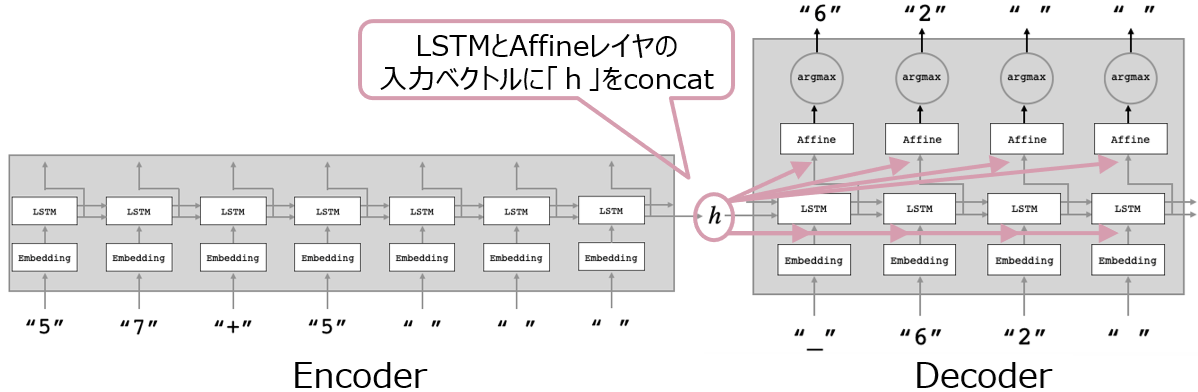

実装については、必要に応じて、[Decoder](#Decoder)とDiffして下さい。

##### Decoderの実装

In [ ]:
# Peeky版デコーダーの定義
class PeekyDecoder:
    # 初期化メソッド
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 変数の形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # パラメータを初期化
        embed_W = (np.random.randn(V, D) * 0.01).astype('f')
        #lstm_Wx = (np.random.randn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wx = (np.random.randn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (np.random.randn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        #affine_W = (np.random.randn(H, V) / np.sqrt(H)).astype('f')
        affine_W = (np.random.randn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤを生成
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        # パラメータと勾配をリストに格納
        self.params = [] # パラメータ
        self.grads = []  # 勾配
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
        # --- 追加 ----------
        # 中間変数の受け皿
        self.cache = None
        # -------------------
        
    # 順伝播メソッド
    def forward(self, xs, h):
        # --- 追加 ----------
        # 変数の形状に関する値を取得
        N, T = xs.shape
        N, H = h.shape
        # -------------------
        
        # Encoderの隠れ状態を入力
        self.lstm.set_state(h)
        
        # 各レイヤの順伝播を計算
        # Time Embedレイヤの順伝播を計算
        out = self.embed.forward(xs)
        # --- 追加 ----------
        # Encoderの隠れ状態を複製
        hs = np.repeat(h, T, axis=0).reshape((N, T, H))
        # Encoderの隠れ状態(複製)と単語ベクトルを結合
        out = np.concatenate((hs, out), axis=2)
        # -------------------
        # Time LSTMレイヤの順伝播を計算
        out = self.lstm.forward(out)
        # --- 追加 ----------
        # Encoderの隠れ状態(複製)とDecoderの隠れ状態を結合
        out = np.concatenate((hs, out), axis=2)
        # -------------------
        # Time Affineレイヤの順伝播を計算
        score = self.affine.forward(out)
        
        # --- 追加 ----------
        # 逆伝播用に変数の形状に関する値を保存
        self.cache = H
        # -------------------
        
        return score
    
    # 逆伝播メソッド
    def backward(self, dscore):
        
        # --- 追加 ----------
        # 変数の形状に関する値を取得
        H = self.cache
        # -------------------
        
        # 各レイヤの逆伝播を逆順に計算
        # Time Affineレイヤの逆伝播を計算
        dout = self.affine.backward(dscore)
        
        # --- 追加 ----------
        # 勾配を分割
        dhs0 = dout[:, :, :H] # Encoderの隠れ状態(複製)の勾配
        dout = dout[:, :, H:] # Decoderの隠れ状態の勾配
        # -------------------
        
        # Time LSTMレイヤの逆伝播を計算
        dout = self.lstm.backward(dout)
        
        # --- 追加 ----------
        # 勾配を分割
        dhs1 = dout[:, :, :H]   # Encoderの隠れ状態(複製)の勾配
        dembed = dout[:, :, H:] # 単語ベクトルの勾配
        # -------------------
        
        # Time Embedレイヤの逆伝播を計算
        dout = self.embed.backward(dembed) # 返り値はNone
        
        # --- 追加 ----------
        # Encoderの隠れ状態の勾配を計算
        dhs = dhs0 + dhs1
        dh = np.sum(dhs, axis=1)
        # -------------------
        
        # EncoderのT-1番目の隠れ状態の勾配を合算してをEncoderに出力
        dh += self.lstm.dh
        return dh
    
    # 文章生成メソッド
    def generate(self, h, start_id, sample_size):
        # 文字IDの受け皿を初期化
        sampled = []
        
        # 区切り文字のIDを設定
        sample_id = start_id
        
        # エンコードされた足し算の式を入力
        self.lstm.set_state(h)
        
        # 解答を生成
        
        # --- 追加 ----------
        H = h.shape[1]
        peeky_h = h.reshape((1, 1, H))
        # -------------------
        
        for _ in range(sample_size):
            # 入力用に2次元配列に変換
            x = np.array(sample_id).reshape((1, 1))
            
            # スコアを計算
            out = self.embed.forward(x)
            # --- 追加 ----------
            out = np.concatenate((peeky_h, out), axis=2)
            # -------------------
            out = self.lstm.forward(out)
            # --- 追加 ----------
            out = np.concatenate((peeky_h, out), axis=2)
            # -------------------
            score = self.affine.forward(out)
            
            # スコアが最大の文字IDを取得
            sample_id = np.argmax(score.flatten()) # 入力データを更新
            sampled.append(sample_id) # サンプルを保存
        
        return sampled

##### seq2seqの実装
- 実装については、必要に応じて、[Encoder-Decoder](#Encoder-Decoder)とDiffして下さい。
- Seq2seqを継承しているので、overridesした"\_\_init\_\_"メソッドのみがとDiff対象になります。

In [ ]:
# seq2seqの実装
class PeekySeq2seq(Seq2seq):
    # 初期化メソッド
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        # 変数の形状に関する値を取得
        V, D, H = vocab_size, wordvec_size, hidden_size
        
        # 各レイヤのインスタンスを作成
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()
        
        # パラメータと勾配をリストに格納
        self.params = self.encoder.params + self.decoder.params # パラメータ
        self.grads = self.encoder.grads + self.decoder.grads    # 勾配

##### 学習

In [ ]:
# インスタンスを作成
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 正解率の記録用のリストを初期化
peeky_reverse_acc_list = []

# 繰り返し試行
for epoch in range(max_epoch):
    # 学習
    trainer.fit(reverse_x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad)
    
    # 正解数を初期化
    correct_num = 0
    
    # 精度を測定
    for n in range(len(reverse_x_test)):
        # データを取得
        question = reverse_x_test[[n]] # Encoderの入力データ(足し算の式)
        start_id = t_test[n, 0]        # Decoderの入力データの最初の文字(区切り文字)
        correct = t_test[n, 1:]        # 教師データ(足し算の答)
        
        # 解答を生成
        guess = model.generate(question, start_id, len(correct))
        
        # 正解数をカウント
        if guess == list(correct): # 解答と答が一致したら
            correct_num += 1
    
    # 正解率を計算
    acc = float(correct_num) / len(reverse_x_test)
    peeky_reverse_acc_list.append(acc)
    
    # 途中経過を表示
    print('val acc:' + str(acc * 100))

###### 学習結果を表示する。

In [ ]:
# 正解率の記録をグラフ化
plt.figure(figsize=(9, 6))

plt.plot(1 + np.arange(len(acc_list)), acc_list, 
         marker='o', label='baseline')

plt.plot(1 + np.arange(len(reverse_acc_list)), reverse_acc_list, 
         marker='D', label='reverse')

plt.plot(1 + np.arange(len(peeky_reverse_acc_list)), peeky_reverse_acc_list, 
         marker='v', label='reverse + peeky')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('seq2seq', fontsize=20)
plt.ylim(0, 1) # y軸の表示範囲
plt.legend() # 凡例
plt.grid() # グリッド線
plt.show()

###### 学習結果をロードする。

In [ ]:
# 保存と復元
import pickle

# 保存されるオブジェクト
#obj = [acc_list, reverse_acc_list, peeky_reverse_acc_list]

# シリアライズ相当
#with open('../work/NekozameRNN3_acc_list.pickle','wb') as f:
#   pickle.dump(obj, f)

# デシリアライズ相当
with open('../work/NekozameRNN3_acc_list.pickle','rb') as f:
   loaded_obj = pickle.load(f)

acc_list, reverse_acc_list, peeky_reverse_acc_list = loaded_obj